# GPyOpt: configuring a GPy model :)

### Written by Javier Gonzalez, Zhenwen Dai and Zwiessele, University of Sheffield.

*Last updated Tuesday, 3 Jun 2016.*

The goal of this notebook is to use GPyOpt to tune the parameters of Machine Learning algorithms. In particular, we will shows how to tune the hyper-parameters for GPy models.

We start loading the requires modules.

In [1]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
from sklearn import svm
from numpy.random import seed
seed(12345)

Populating the interactive namespace from numpy and matplotlib
warning in stationary: failed to import cython module: falling back to numpy


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 20 days


For this example we will use the Olympic marathon dataset available in GPy. 
We split the original dataset into the training data (first 20 data points) and testing data (last 7 data points). 

In [11]:
# Let's load the dataset
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']
X_train = X[:20]
Y_train = Y[:20]
X_test = X[20:]
Y_test = Y[20:]

Let's first create a GPy model.

In [157]:
from GPy.models import GPRegression

k = GPy.kern.Matern32(1, variance=2, lengthscale=1)\
+GPy.kern.Linear(1, variances=1)\
+GPy.kern.Bias(1, variance=5)

m = GPRegression(X_train, Y_train, 
                 kernel=k,
                 normalizer=True,
                )
print m

Y_train_pred, Y_train_pred_var = m.predict(X_train)
Y_test_pred, Y_test_pred_var = m.predict(X_test)


Name : GP regression
Objective : 38.8853678617
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  sum.Mat32.variance       |    2.0  |      +ve      |        
  sum.Mat32.lengthscale    |    1.0  |      +ve      |        
  sum.linear.variances     |    1.0  |      +ve      |        
  sum.bias.variance        |    5.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Does not give an OK fit to the training data but completely miss out the testing data well.

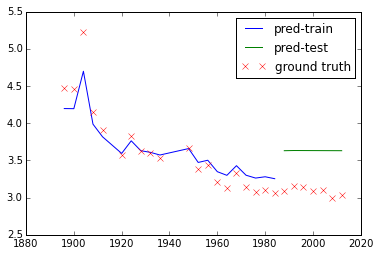

In [160]:
plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')

plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')

Now let's try Bayesian Optimization.

In [161]:
m.parameter_names()

['sum.Mat32.variance',
 'sum.Mat32.lengthscale',
 'sum.linear.variances',
 'sum.bias.variance',
 'Gaussian_noise.variance']

In [134]:
domain = [
{'name': 'Mat32.variance',          'type': 'continuous', 'domain': (1,4.)},
{'name': 'Mat32.lengthscale',       'type': 'continuous', 'domain': (50.,150.)},
{'name': 'Linear.variances',        'type': 'continuous', 'domain': (1e-5,6)},
{'name': 'Bias.variance',           'type': 'continuous', 'domain': (1e-5,6)},
{'name': 'Gaussian_noise.variance', 'type': 'continuous', 'domain': (1e-5,4.)}
]

We, then, create the GPyOpt object and run the optimization procedure. It might take a while.

In [135]:
def f_lik(x):
    m[:] = x
    return m.objective_function()

In [147]:
opt = GPyOpt.methods.BayesianOptimization(f = f_lik,            # function to optimize       
                                          domain = domain,
                                          model_type= 'GP_MCMC',# box-constrains of the problem
                                          acquisition_type ='EI_MCMC',       # LCB acquisition
                                          acquisition_jitter = 0.1)   # Exploration exploitation

** GPyOpt Bayesian Optimization class initialized succesfuly **


   ** Maximum number of iterations reached **


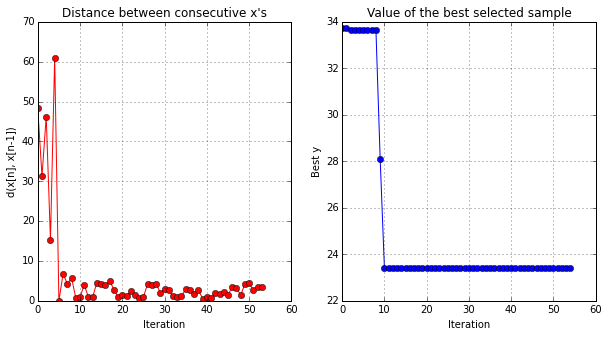

In [148]:
# it may take a few seconds
opt.run_optimization(max_iter=50)
opt.plot_convergence()

Let's show the best parameters found. They differ significantly from the default parameters.

In [149]:
x_best = opt.X[np.argmin(opt.Y)].copy()

m[:] = x_best

print "The best model found:"
print m

Y_train_pred, Y_train_pred_var = m.predict(X_train)
Y_test_pred, Y_test_pred_var = m.predict(X_test)

The best model found:

Name : GP regression
Objective : 23.4233792457
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  sum.Mat32.variance       |             4.0  |      +ve      |        
  sum.Mat32.lengthscale    |   114.269541031  |      +ve      |        
  sum.linear.variances     |   2.14403934229  |      +ve      |        
  sum.bias.variance        |    4.5365598091  |      +ve      |        
  Gaussian_noise.variance  |  0.407834178548  |      +ve      |        


We can see SVR does a reasonable fit to the data. The result could be further improved by increasing the *max_iter*. 

RMSE = 0.0543651517608


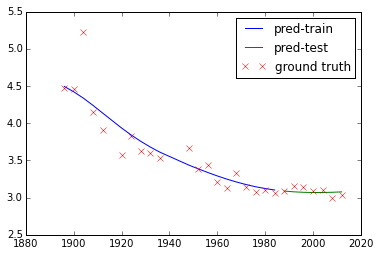

In [150]:
plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')

plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')

In [163]:
m[:] = opt.X[0].copy()

In [164]:
m.optimize()

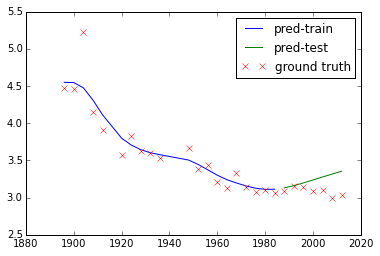

In [165]:
Y_train_pred, Y_train_pred_var = m.predict(X_train)
Y_test_pred, Y_test_pred_var = m.predict(X_test)

plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')

plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')